In [ ]:
import pickle
import time

import numpy as np
from gep_config_parser import *
from data_wrangling import dataframe_to_dict

from primal_dual import PrimalDualTrainer
from gep_problem import GEPProblemSet
from gep_problem_operational import GEPOperationalProblemSet
from gep_main import run_model as run_Gurobi
from gep_main import run_model_no_bounds as run_Gurobi_no_bounds
from get_gurobi_vars import OptValueExtractor
import sys
import torch

import pyomo as pyo

CONFIG_FILE_NAME        = "config.toml"
VISUALIZATION_FILE_NAME = "visualization.toml"


SCALE_FACTORS = {
    "pDemand": 1/1000,  # MW -> GW
    "pGenAva": 1,       # Don't scale
    "pVOLL": 1/1000,         # kEUR/MWh -> mEUR/GWh
    "pWeight": 1,       # Don't scale
    "pRamping": 1,      # Don't scale
    "pInvCost": 1/1000,      # kEUR/MW -> mEUR/GW
    "pVarCost": 1/1000,      # kEUR/MWh -> mEUR/GWh
    "pUnitCap": 1/1000, # MW -> GW
    "pExpCap": 1/1000,  # MW -> GW
    "pImpCap": 1/1000,  # MW -> GW
}

def scale_dict(data_dict, scale_factor):
    return {key: value * scale_factor for key, value in data_dict.items()}


## Step 1: parse the input data
print("Parsing the config file")

data = parse_config(CONFIG_FILE_NAME)
experiment = data["experiment"]
outputs_config = data["outputs_config"]


def prep_data(inputs, scale_input=False, train=0.8, valid=0.1, test=0.1, scale=True, sample_duration=12, constant_gen_inv=False):
    print("Wrangling the input data")

    # Extract sets
    T = inputs["times"] # [1, 2, 3, ... 8760] ---> 8760
    G = inputs["generators"] # [('Country1', 'EnergySource1'), ...] ---> 107
    L = inputs["transmission_lines"] # [('Country1', 'Country2'), ...] ---> 44
    N = inputs["nodes"] # ['Country1', 'Country2', ...] ---> 20

    ### SET UP CUSTOM CONFIG ###å
    # N = ['BEL', 'FRA', 'GER', 'NED'] # 4 nodes
    # N = ['BEL', 'GER', 'NED'] # 3 nodes
    N = ['BEL', 'GER'] # 2 nodes
    # G = [('BEL', 'SunPV'), ('GER', 'SunPV'), ('NED', 'SunPV')] # 3 generators
    # G = [('BEL', 'SunPV'), ('BEL', 'Gas'), ('BEL', 'Oil'), ('BEL', 'WindOn'), ('BEL', 'WindOff'),
    #      ('GER', 'SunPV'), ('GER', 'Coal'), ('GER', 'Gas'), ('GER', 'Oil'), ('GER', 'WindOn'), ('GER', 'WindOff'),
    #      ('NED', 'SunPV'), ('NED', 'WindOn'), ('NED', 'WindOff')] # All generators
    # G = [('BEL', 'SunPV'), ('BEL', 'Gas'),
        #  ('GER', 'SunPV'), ('GER', 'Gas'),
        #  ('NED', 'SunPV')] # Only sun and gas
    # G = [('BEL', 'Gas'),
        #  ('GER', 'Gas'),] # Only gas
    G = [('BEL', 'SunPV'), ('GER', 'SunPV')]
    # L = [('BEL', 'FRA'), ('BEL', 'GER'), ('BEL', 'NED'), ('GER', 'FRA'), ('GER', 'NED')] # 5 lines
    # L = [('BEL', 'GER'), ('BEL', 'NED'), ('GER', 'NED')] # 3 lines
    L = [('BEL', 'GER')] # 2 lines

    # Extract time series data
    pDemand = dataframe_to_dict(
        inputs["demand_data"],
        keys=["Country", "Time"],
        value="Demand_MW"
    )
    
    pGenAva = dataframe_to_dict(
        inputs["generation_availability_data"],
        keys=["Country", "Technology", "Time"],
        value="Availability_pu"
    )

    # Extract scalar parameters
    pVOLL = inputs["value_of_lost_load"]

    # WOP
    # Scale inversely proportional to times (T)
    pWeight = inputs["representative_period_weight"] / (sample_duration / 8760)

    pRamping = inputs["ramping_value"]

    # Extract generator parameters
    pInvCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="InvCost_kEUR_MW_year"
    )

    pVarCost = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="VarCost_kEUR_per_MWh"
    )

    pUnitCap = dataframe_to_dict(
        inputs["generation_data"],
        keys=["Country", "Technology"],
        value="UnitCap_MW"
    )

    # Extract line parameters
    pExpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ExpCap_MW"
    )

    pImpCap = dataframe_to_dict(
        inputs["transmission_lines_data"],
        keys=["CountryA", "CountryB"],
        value="ImpCap_MW"
    )

    if scale:
        pDemand = scale_dict(pDemand, SCALE_FACTORS["pDemand"])
        pGenAva = scale_dict(pGenAva, SCALE_FACTORS["pGenAva"])
        pVOLL *= SCALE_FACTORS["pVOLL"]
        pWeight *= SCALE_FACTORS["pWeight"]
        pRamping *= SCALE_FACTORS["pRamping"]
        pInvCost = scale_dict(pInvCost, SCALE_FACTORS["pInvCost"])
        pVarCost = scale_dict(pVarCost, SCALE_FACTORS["pVarCost"])
        pUnitCap = scale_dict(pUnitCap, SCALE_FACTORS["pUnitCap"])
        pExpCap = scale_dict(pExpCap, SCALE_FACTORS["pExpCap"])
        pImpCap = scale_dict(pImpCap, SCALE_FACTORS["pImpCap"])


    # We need to sort the dictionaries for changing to tensors!
    pDemand = dict(sorted(pDemand.items()))
    pGenAva = dict(sorted(pGenAva.items()))
    pInvCost = dict(sorted(pInvCost.items()))
    pVarCost = dict(sorted(pVarCost.items()))
    pUnitCap = dict(sorted(pUnitCap.items()))
    pExpCap = dict(sorted(pExpCap.items()))
    pImpCap = dict(sorted(pImpCap.items()))


    print("Creating problem instance")
    if constant_gen_inv:
        data = GEPOperationalProblemSet(T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, sample_duration=sample_duration, train=train, valid=valid, test=test)
    else:
        data = GEPProblemSet(T, N, G, L, pDemand, pGenAva, pVOLL, pWeight, pRamping, pInvCost, pVarCost, pUnitCap, pExpCap, pImpCap, sample_duration=sample_duration, train=train, valid=valid, test=test)

    return data

def run_PDL(data, args, save_dir, optimal_objective_train=None, optimal_objective_val=None):
    # Run PDL
    print("Training the PDL")
    trainer = PrimalDualTrainer(data, args, save_dir, optimal_objective_train=optimal_objective_train, optimal_objective_val=optimal_objective_val)
    primal_net, dual_net, stats = trainer.train_PDL()

    return primal_net, dual_net

if __name__ == "__main__":
    args = {
            "K": 1,
            # "K": 10,
            "L": 1,
            # "L": 1000,
            # "L": 2000,
            "tau": 0.8,
            # "rho": 0.1,
            # "rho": 0.2,
            "rho": 0.5,
            # "rho": 0.1,
            # "rho_max": 10,
            "rho_max": 5000,
            # "rho_max": 100,
            # "rho_max": sys.maxsize * 2 + 1,
            "alpha": 10,
            # "alpha": 2,
            "batch_size": 100,
            # "batch_size": 1,
            "hidden_sizes": [500, 500],
            # "hidden_sizes": [1000, 1000, 1000, 1000],
            # "hidden_sizes": [500, 500, 500, 500],
            # "hidden_size": 1000,
            # "primal_lr": 1e-4,
            "primal_lr": 1e-4,
            "dual_lr": 1e-4,
            # "primal_lr": 1e-5,
            # "dual_lr": 1e-5,
            # "decay": 0.99,
            "decay": 0.99,
            "patience": 10,
            "corrEps": 1e-4,
            "shuffle": False,
            "scale_input": False,
            # "train": 0.002, # 1 sample
            # "valid": 0.002,
            # "test": 0.996,
            "train": 0.004, # 2 samples
            "valid": 0.004,
            "test": 0.992,
            # "train": 0.8,
            # "valid": 0.1,
            # "test": 0.1,
            # "train": 0.004,
            # "valid": 0.004,
            # "test": 0.992,
            "sample_duration": 24,
            "operational": True,
            # "train": 0.02,
            # "valid": 0.02,
            # "test": 0.96,
    }

    # Train the model:
    for i, experiment_instance in enumerate(experiment["experiments"]):
        # Setup output dataframe
        df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

        for j in range(experiment["repeats"]):
            # Run one experiment for j repeats
            run_name = f"refactored_train:{args['train']}_rho:{args['rho']}_rhomax:{args['rho_max']}_alpha:{args['alpha']}_L:{args['alpha']}_scaled:{args['scale_input']}"
            save_dir = os.path.join('outputs', 'PDL',
                run_name + "-" + str(time.time()).replace('.', '-'))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            with open(os.path.join(save_dir, 'args.dict'), 'wb') as f:
                pickle.dump(args, f)
            
            # Prep proble data:
            data = prep_data(experiment_instance, train=args["train"], valid=args["valid"], test=args["test"], sample_duration=args["sample_duration"], constant_gen_inv=args["operational"])

            # Run PDL
            primal_net, dual_net = run_PDL(data, args, save_dir)




Running on cpu
Parsing the config file
Initializing the solver
Using Gurobi
Parsing the config file
Wrangling the input data
Creating problem instance
Populating ineq constraints
Populating eq constraints
Creating objective coefficients
Creating input for NN: X
Size of train set: 1
Size of val set: 1
Size of test set: 363
Training the PDL
X dim: 288
Y dim: 120
Size of mu: 240
Size of lambda: 48
Epoch 0 done. Time taken: 2.278778076171875. Rho: 0.5. Primal LR: 0.0001, Dual LR: 0.0001


In [2]:
X = data.X[:1]
eq_cm = data.eq_cm[:1]
ineq_cm = data.ineq_cm[:1]
eq_rhs = data.eq_rhs[:1]
ineq_rhs = data.ineq_rhs[:1]
print(ineq_rhs)

p_gt_lb, p_gt_ub, f_lt_lb, f_lt_ub, md_nt_lb, md_nt_ub = data.split_ineq_constraints(ineq_rhs)
print(md_nt_lb)
print(md_nt_ub)


tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,
           0.0000,   5.3364,  33.0617,   0.0000,   0.0000,   0.0000,   0.0000,
           2.0000,   2.3800,   0.0000,   0.0000,   4.8846,  31.4492,   0.0000,
           0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,   0.0000,
           4.4897,  29.7278,   0.0000,   0.0000,   0.0000,   0.0000,   2.0000,
           2.3800,   0.0000,   0.0000,   4.1595,  28.2646,   0.0000,   0.0000,
           0.0000,   0.0000,   2.0000,   2.3800,   0.0000,   0.0000,   3.8910,
          27.5760,   0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,
           0.0000,   0.0000,   3.7783,  26.8135,   0.0000,   0.0000,   0.0000,
           0.0000,   2.0000,   2.3800,   0.0000,   0.0000,   3.8175,  25.2942,
           0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,
           0.0000,   3.5666,  25.5733,   0.0000,   0.0000,   5.1626,  24.7116,
           2.0000,   2.3800,   0.0000,   0.0000,   3

In [3]:
Y = primal_net(X, eq_rhs, ineq_rhs)
ineq_resid = data.ineq_resid(Y, ineq_cm, ineq_rhs)

p_gt, f_lt, md_nt = data.split_dec_vars_from_Y(Y)
p_gt_lb, p_gt_ub, f_lt_lb, f_lt_ub, md_nt_lb, md_nt_ub = data.split_ineq_constraints(ineq_rhs)

print(p_gt)
print(p_gt_lb)
print(p_gt_ub)

# Check generation bounds
for b in range(p_gt.shape[0]):
    for g in range(p_gt.shape[1]):
        for t in range(p_gt.shape[2]):
            assert(p_gt_lb[b][g, t] <= p_gt[b][g, t] <= p_gt_ub[b][g, t])

# Check lineflow bounds
for b in range(f_lt.shape[0]):
    for l in range(f_lt.shape[1]):
        for t in range(f_lt.shape[2]):
            assert(-f_lt_lb[b][l, t] <= f_lt[b][l, t] <= f_lt_ub[b][l, t])

# md_nt bounds aren't enforced.


p_gt_lb, p_gt_ub, f_lt_lb, f_lt_ub, md_nt_lb, md_nt_ub = data.split_ineq_constraints(ineq_resid)
print(p_gt_lb)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9449e+00, 0.0000e+00,
          5.5136e+01, 0.0000e+00, 1.1399e-04, 0.0000e+00, 0.0000e+00,
          6.6081e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4712e+01, 0.0000e+00,
          9.8285e+01, 1.3362e-04, 1.1626e+02, 8.8737e+01, 0.0000e+00,
          9.1364e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]],
       grad_fn=<SplitWithSizesBackward0>)
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]])
tensor([[[  0.0000,   0.0000,   0.0000,   

In [4]:
x_out = torch.tensor([[1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1, 1, 2,-1]])
print(x_out.shape)
print(x_out)

def split_dec_vars_from_Y_raw(self, Y):
        """Groups the decision variables from the NN output BEFORE REPAIRS by type.
            Assume y =  [p_{g,t0}, f_{l,t0}, 
                         p_{g,t1}, f_{l,t1}, ..., 
                         p_{g,tn}, f_{l,tn}] (per sample in batch)

            Returns p_{g,t}, f_{l,t}
        """
        batch_size = Y.shape[0]  # Get batch size

        # Reshape Y for efficient slicing
        Y = Y.view(batch_size, self.sample_duration, self.n_var_per_t - self.num_n).permute(0, 2, 1)

        # Define segment sizes
        sizes = [self.num_g, self.num_l]

        # Extract constraint tensors
        p_gt, f_lt = torch.split(Y, sizes, dim=1)

        return p_gt, f_lt

# [B, G, T], [B, L, T]
p_gt, f_lt = split_dec_vars_from_Y_raw(data, x_out)

print(p_gt)
print("-----------------------------")
print(f_lt)

torch.Size([1, 72])
tensor([[ 1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,
          1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,
          1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,
          1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1,  1,  2, -1]])
tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2]]])
-----------------------------
tensor([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
          -1, -1, -1, -1, -1, -1, -1]]])


In [5]:
print(ineq_rhs.shape)
print(ineq_rhs)

def split_ineq_constraints(self, ineq):
        """Groups the inequality [residuals or RHS] into constraints by constraint type.
            Assume ineq = [3.1h, 3.1b, 3.1d, 3.1e, 3.1i, 3,1j] * T (per sample in batch)

            returns each constraint type in the form [Batchsize, nr_of_constraints, time]

            Returns h, b, d, e, i, j
        """
        batch_size = ineq.shape[0]  # Get batch size

        # Reshape ineq to [batch_size, sample_duration, n_ineq_per_t]
        # This keeps constraints grouped per time step
        ineq = ineq.view(batch_size, self.sample_duration, self.n_ineq_per_t).permute(0, 2, 1)

        # Define segment sizes based on multiple constraints per type
        sizes = [self.num_g, self.num_g, self.num_l, self.num_l, self.num_n, self.num_n]  # Num constraints per type

        # Extract constraint tensors along the first dimension (constraint type)
        h, b, d, e, i, j = torch.split(ineq, sizes, dim=1)

        return h, b, d, e, i, j

p_gt_lb, p_gt_ub, f_lt_lb, f_lt_ub, md_nt_lb, md_nt_ub = split_ineq_constraints(data, ineq_rhs)
print(p_gt_lb)
print(p_gt_ub)

torch.Size([1, 240])
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,
           0.0000,   5.3364,  33.0617,   0.0000,   0.0000,   0.0000,   0.0000,
           2.0000,   2.3800,   0.0000,   0.0000,   4.8846,  31.4492,   0.0000,
           0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,   0.0000,
           4.4897,  29.7278,   0.0000,   0.0000,   0.0000,   0.0000,   2.0000,
           2.3800,   0.0000,   0.0000,   4.1595,  28.2646,   0.0000,   0.0000,
           0.0000,   0.0000,   2.0000,   2.3800,   0.0000,   0.0000,   3.8910,
          27.5760,   0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,
           0.0000,   0.0000,   3.7783,  26.8135,   0.0000,   0.0000,   0.0000,
           0.0000,   2.0000,   2.3800,   0.0000,   0.0000,   3.8175,  25.2942,
           0.0000,   0.0000,   0.0000,   0.0000,   2.0000,   2.3800,   0.0000,
           0.0000,   3.5666,  25.5733,   0.0000,   0.0000,   5.1626,  24.7116,
           2.0000,   2.3800,   

In [6]:
print(p_gt.shape)

def bound_repair(x, lb, ub):
    # return lb + (ub - lb) * torch.sigmoid(x)
    # x = torch.clamp(x, lb, ub)
    return (lb + (ub - lb)/2 * (torch.tanh(x) + 1))

p_gt_repaired = bound_repair(p_gt, p_gt_lb, p_gt_ub)
f_lt_repaired = bound_repair(f_lt, -f_lt_lb, f_lt_ub)

print(p_gt_repaired)
print(f_lt_repaired)

torch.Size([1, 2, 24])
tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   4.5472,  32.3759,  48.5638,  65.6611,  66.9343,  50.7464,
           28.1925,   5.8204,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  24.2671,  69.4923,  96.5170, 113.6144, 114.1659,  87.1411,
           35.2977,   1.1031,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]]])
tensor([[[-1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779,
          -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779,
          -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779,
          -1.4779, -1.4779, -1.4779]]])


In [7]:
def forward_slack(self, p_gt, f_lt, D_nt):
        """Compute md_n,t

        Args:
            p_gt (_type_): Generator production, shape [B, G, T]
            f_lt (_type_): Line flow, shape [B, L, T]
            D_nt (_type_): Demand, shape [B, N, T]
        """

        # Map generator production to nodes
        p_nt = torch.einsum('ng,bgt->bnt', self.node_to_gen_mask.to(dtype=torch.float64), p_gt)

        print(p_nt)

        # In lineflow mask (adjacency matrix) starting nodes are -1, receiving nodes are 1.
        # Thus, this mask is f_in_nt - f_out_nt (net_flow)
        net_flow_nt = torch.einsum('nl,blt->bnt', self.lineflow_mask.to(dtype=torch.float64), f_lt)
        print(net_flow_nt)
        # Compute md_n,t
        md_nt = D_nt - (p_nt + net_flow_nt)  # [B, N, T]

        # return torch.abs(md_nt.view(B, -1))
        return md_nt

def split_eq_constraints(self, eq):
        """Groups the inequality [residuals or RHS] into constraints by constraint type.
            Assume ineq = [3.1c] * T (per sample in batch)

            returns each constraint type in the form [Batchsize, nr_of_constraints, time]

            Returns c
        """
        batch_size = eq.shape[0]
        c = eq.view(batch_size, self.sample_duration, self.n_eq_per_t).permute(0, 2, 1)
        return c

D_nt = split_eq_constraints(data, eq_rhs)

md_nt = forward_slack(data, p_gt_repaired, f_lt_repaired, D_nt)

print(p_gt_repaired.shape)
print(f_lt_repaired.shape)
print(md_nt.shape)

y = torch.cat([p_gt_repaired, f_lt_repaired, md_nt], dim=1).permute(0, 2, 1).reshape(x_out.shape[0], -1)

print(y)



tensor([[[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   4.5472,  32.3759,  48.5638,  65.6611,  66.9343,  50.7464,
           28.1925,   5.8204,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,  24.2671,  69.4923,  96.5170, 113.6144, 114.1659,  87.1411,
           35.2977,   1.1031,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]]])
tensor([[[ 1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,
           1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,
           1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,  1.4779,
           1.4779,  1.4779,  1.4779],
         [-1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779,
          -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779, -1.4779,
          -1.4779, -1.4779, -1.47

In [8]:
eq_rhs = torch.tensor([[1, 11, 2, 12, 3, 13, 4, 14, 5, 15, 6, 16, 7, 17, 8, 18, 9, 19, 10, 110, 11, 111, 12, 112, 13, 113, 14, 114, 15, 115, 16, 116, 17, 117, 18, 118, 19, 119, 20, 120, 21, 121, 22, 122, 23, 123, 24, 124]], dtype=torch.float64)

p_gt_repaired = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [11, 12, 13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]]], dtype=torch.float64)

f_lt_repaired = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]], dtype=torch.float64)

D_nt = split_eq_constraints(data, eq_rhs)

# print(D_nt.shape)
# print(f_lt_repaired.shape)

md_nt = forward_slack(data, p_gt_repaired, f_lt_repaired, D_nt)

print(md_nt)

y = torch.cat([p_gt_repaired, f_lt_repaired, md_nt], dim=1).permute(0, 2, 1).reshape(x_out.shape[0], -1)

print(y.shape)

eq_resid = torch.bmm(eq_cm, y.unsqueeze(-1)).squeeze(-1)
print(eq_resid)

eq_resid = eq_resid - eq_rhs 

print(eq_resid)

print(data.eq_rhs[0])

tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.],
         [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19., 110., 111.,
          112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
          123., 124.]]])
tensor([[[ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
          -12., -13., -14., -15., -16., -17., -18., -19., -20., -21., -22.,
          -23., -24.],
         [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.]]])
tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.],
         [ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
          -12., -13., -14., -15., -16., -17.,

In [9]:
eq_rhs = torch.tensor([[1, 11, 2, 12, 3, 13, 4, 14, 5, 15, 6, 16, 7, 17, 8, 18, 9, 19, 10, 110, 11, 111, 12, 112, 13, 113, 14, 114, 15, 115, 16, 116, 17, 117, 18, 118, 19, 119, 20, 120, 21, 121, 22, 122, 23, 123, 24, 124]], dtype=torch.float64)

p_gt_repaired = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], [11, 12, 13, 14, 15, 16, 17, 18, 19, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]]], dtype=torch.float64)

f_lt_repaired = torch.tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]], dtype=torch.float64)

D_nt = split_eq_constraints(data, eq_rhs)

# print(D_nt.shape)
# print(f_lt_repaired.shape)

md_nt = forward_slack(data, p_gt_repaired, f_lt_repaired, D_nt)

print(md_nt)

y = torch.cat([p_gt_repaired, f_lt_repaired, md_nt], dim=1).permute(0, 2, 1).reshape(x_out.shape[0], -1)

print(y.shape)

eq_resid = torch.bmm(eq_cm, y.unsqueeze(-1)).squeeze(-1) - eq_rhs 
print(eq_resid)

# eq_resid = eq_resid - 

# print(eq_resid)

# print(data.eq_rhs[0])

tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.],
         [ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19., 110., 111.,
          112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
          123., 124.]]])
tensor([[[ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
          -12., -13., -14., -15., -16., -17., -18., -19., -20., -21., -22.,
          -23., -24.],
         [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.]]])
tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
           12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
           23.,  24.],
         [ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
          -12., -13., -14., -15., -16., -17.,

In [14]:
X = data.X
eq_cm = data.eq_cm
ineq_cm = data.ineq_cm
eq_rhs = data.eq_rhs
ineq_rhs = data.ineq_rhs

# print(eq_cm)
# print(eq_rhs)
Y = primal_net(X, eq_rhs, ineq_rhs)
print(Y)
print('-'*40)
p_gt, f_lt, md_nt = data.split_dec_vars_from_Y(Y)
print(p_gt)
print(f_lt)
D_nt = data.split_eq_constraints(eq_rhs)
print(D_nt)

print('-'*40)
md_nt = forward_slack(data, p_gt, f_lt, D_nt)
print(md_nt)

print('-'*40)
y = torch.cat([p_gt, f_lt, md_nt], dim=1).permute(0, 2, 1).reshape(X.shape[0], -1)
print(y)

print(data.eq_resid(y, eq_cm, eq_rhs)[:1])
# print(md_nt)
# print(Y[0, :5])
# print(eq_rhs[0, :2])

tensor([[  0.0000,   0.0000,  -2.0000,  ...,   2.3800,  43.8548, -12.2146],
        [  0.0000,   0.0000,  -2.0000,  ...,   1.9217,  20.6699,   8.4579],
        [  0.0000,   0.0000,  -2.0000,  ...,  -2.0000,   6.9499,  19.6240],
        ...,
        [  0.0000,   0.0000,  -2.0000,  ...,   2.3781,  26.0483, -12.7208],
        [  0.0000,   0.0000,  -2.0000,  ...,   2.3800,  28.0157,  -4.4571],
        [  0.0000,   0.0000,  -2.0000,  ...,   2.3800,  37.0800,  -9.6700]],
       grad_fn=<UnsafeViewBackward0>)
----------------------------------------
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0.,

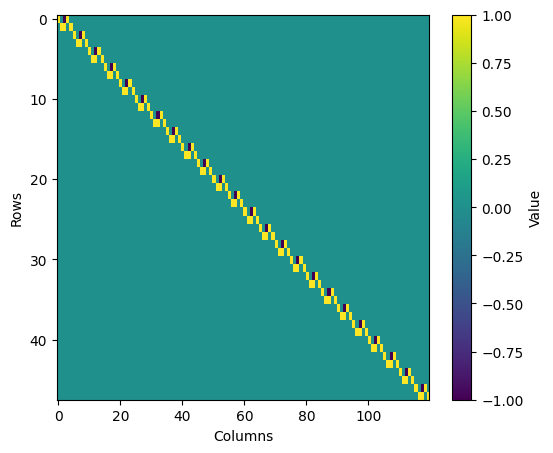

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(data.eq_cm[0], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

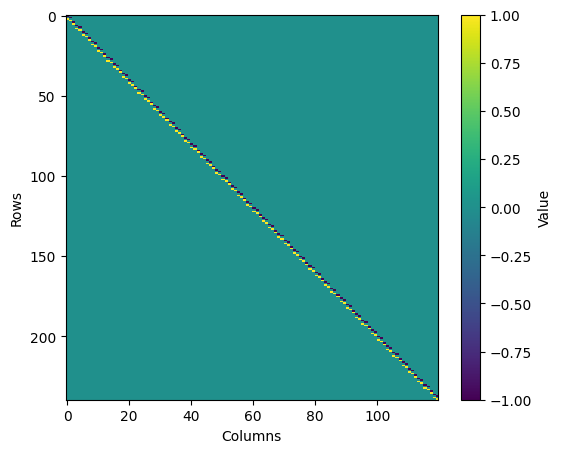

In [ ]:
plt.figure(figsize=(6, 5))
plt.imshow(ineq_cm[0], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()